In [11]:
import igraph as ig
from igraph import Graph

class DBGraph:
    newid = 0
    k = 4 # we need to know the k-mer size (note: the length of the sequence per node is k-1)
    igraph = None
    name = ""
    compacted = False
    sequence = ""
    def __init__(self, name="", k=4):
        self.name = name
        self.k = k
        self.igraph = Graph(directed=True)    
        
    def vcount(self):
        return self.igraph.vcount()
    
    # utility function to quickly retrieve the edge between two igraph nodes
    # this function should exist in igraph itself
    def edge(self, n1, n2):
        gl = self.igraph
        return gl.es[gl.get_eid(n1.index, n2.index)]
        
    """
   
   utility function: adds the node sequences to the graph
    
    """
    
    def add(self, s1, s2):
        if self.compacted:
            raise Exception("New nodes cannot be added to a compacted graph.")
        n1 = n2 = None
        try:
            n1 = self.igraph.vs.find(sequence=s1)     
        except:
            self.igraph.add_vertices(1)
            n1 = self.igraph.vs[self.newid]
            n1["name"] = n1["sequence"] = s1
            n1['label'] = '['+ str(n1.index) +'] '+ s1
            n1['id'] = n1.index
            n1['visited'] = False
            n1['compacted'] = False
            n1['coverage'] = 1 ## minimum coverage, for plotting
            self.newid += 1            
        try:
            n2 = self.igraph.vs.find(sequence=s2)
        except:            
            self.igraph.add_vertices(1)
            n2 = self.igraph.vs[self.newid]
            n2["name"] = n2["sequence"] = s2
            n2['label'] = '['+ str(n2.index) +'] '+ s2
            n2['id'] = n2.index
            n2['visited'] = False
            n2['compacted'] = False
            n2['coverage'] = 1 ## minimum coverage, for plotting
            self.newid += 1
            
        assert n1 and n2, "Both nodes must exist at this point!"            
        i1 = n1.index
        i2 = n2.index
        print ("adding edge",i1, "-->" , i2)
        eid = None
        try: # the edge could be there already
            eid = self.igraph.get_eid(i1,i2)
            self.igraph.es[eid]["coverage"] += 1 ## in a true DeBrujn Graph the edges carry the multiplicity!
        except: # the edge is new
            self.igraph.add_edges([(i1,i2)])
            eid = self.igraph.get_eid(i1,i2)
            self.igraph.es[eid]["coverage"] = 1 
    
    def add_kmer(self,kmer):
        assert len(kmer) == self.k, "kmer sequence must have length k" 
        self.add(kmer[0:self.k-1], kmer[1:self.k])
        
            

    def get_node0(self):
        return Node(graph=self, id=0)
    
    
    def compact(self):
        if self.compacted:
            raise Exception("Compaction can only be run once per graph")
        self.compacted = True
        ## look for simple 0 start nodes first
        ## only nodes with outdegree can be compacted        
        # for ni in nset0: print(ni["name"])
        i = 0
        # update set of not yet compacted nodes after each iteration
        while True: # this needs to be done this way, otherwise the set is not updated correctly    
            nset0 = self.igraph.vs.select(_outdegree_eq = 1, compacted = False)
            print (i,':', len(nset0))
            if len(nset0) < 1:          
                break
            n = nset0[0]
            i += 1
            print("Start compacting: ", n['name'])         
            assert not n['compacted'], "We hit an already compacted node!" # this should never happen because of select statement
            first_time = True
            # don't take this node again
            # we are going to simply delete the neighbors, there is only one dircet neighbor
            # but we also need to check if the next node is balanced
            n['compacted'] = True # mark this node as compacted, so it won't come up again
            n['sum'] = 0 # compacted nodes store their coverage themselves, sum of coverages
            n['dist'] = 0 # distance forward to next "junction" ahead
            ## This is the actual compaction for node n
            while True: 
                ## exit condition: we don't have exactly 1 successor, or the next node has 
                ## multiple incoming nodes
                if (n.outdegree() != 1 or n.successors()[0].indegree() != 1):
                    break                
                succ = n.successors()[0] # node is linear, so we are sure
                ### don't follow only self-reference:
                if n == succ: break
                
                ## Only the very first node in our path needs to keep the full k-mer, that is a node with in_degree 0
                ## All other need to be clipped now
                if n.indegree() > 0 and first_time: 
                    # otherwise we would artificially prolong the sequence
                    n['sequence'] = n['sequence'][self.k-2] # get only last letter
                    first_time = False # but only once, otherwise we'd chop off the whole sequence
                    
                print("compacting", n['name'], '-->', succ)
                eid = self.igraph.get_eid(n.index, succ.index) # geet the edge id
                ## add edges to all succ.successors to this node
                for s in succ.successors():
                    self.igraph.add_edges([(n.index,s.index)]) ## add a new edge, 
                    new_eid = self.igraph.get_eid(n.index, s.index) ## and get the index of the edge we just made
                    ## we need to copy the coverage attribute over, 
                    ## so get the edge connecting 
                    ## successor to its next successor
                    succ_eid = self.igraph.get_eid(succ.index, s.index)
                    self.igraph.es[new_eid]['coverage'] = self.igraph.es[succ_eid]['coverage']  # copy coverage            
                ## get the successors single character and add to node sequence
                if succ["compacted"]:
                    ## add the sequence of the compacted node, it is already compacted
                    n["sequence"] += succ["sequence"]
                    n["sum"] += succ["sum"]
                    n['dist'] += succ['dist']   
                else:
                    n["sequence"] += succ["sequence"][self.k - 2]
                    n['sum'] += self.igraph.es[eid]['coverage'] # here the coverage is in the edge
                    n['dist'] += 1 # now we have made only a single step                   
                n["name"] = n["sequence"]    
                n['label'] = '['+ str(n.index) +'] '+ n['sequence'] 
                ## now delete the successor and the edge
                eid = self.igraph.get_eid(n.index, succ.index)
                self.igraph.delete_edges(eid)
                self.igraph.delete_vertices(succ.index)
                
        ## Now the compaction is complete, but we still have sum and dist per node, but not coverage, so we need to update
        ## the compacted nodes in a last sweep over all compacted nodes
        for n in self.igraph.vs.select(compacted = True):
            if (n['dist'] == 0): 
                n['coverage'] = 1
                n['compacted'] = False ## these nodes were not really compacted, there were just marked 
            else:
                n['coverage'] = n['sum']/n['dist']
        
            
  
    def viz(self):
        layout = self.igraph.layout("kk")
        color_dict = {True: "lightgreen", False: "tomato"}
        colors = [color_dict[c] for c in self.igraph.vs["compacted"]]
        shapes = []
        visual_style = {}
        visual_style["edge_width"] = [0.5 * int(coverage) for coverage in self.igraph.es["coverage"]]
        visual_style["vertex_size"] = [20 * int(coverage) for coverage in self.igraph.vs["coverage"]]
        for s in self.igraph.vs.indegree():
            if s == 0:
                shapes.append("rectangle")
            else:
                shapes.append("circle")
        self.igraph.vs['label'] = list(map(lambda x: "["+str(x.index)+']'+x['name'], self.igraph.vs))        
        return(ig.plot(self.igraph, bbox=(0, 0, 400, 400), vertex_color=colors, 
                       vertex_shape=shapes, vertex_label_dist = -0.5, layout=layout, **visual_style ))

        
    def print(self):
        print(self.igraph)    
   
    
    ## utility function to get the best node, strategy:
    ## ignore self reference
    ## 0. if no further node: None
    ## 1. if outdegree == 1, get the node
    ## 2. if outdegree > 0, prioritize:
    ##   1) get not visited node with highest coverage
    ## the user is responsible to mark node as visited if it is used
    ## we don't want to hit on an infinite loop, but if a visited node has an unvisited next node
    ## it could still be part of an Eulerian walk
    def get_next_node(self, n):
        
        if (n.outdegree() < 1): return None
        if (len(n.successors()) == 1):
            nn = n.successors()[0] ## there is only one, return it but only if it is not self referential
            if n == nn: # self reference
                return None 
            else: 
                return nn
        
        nset = n.successors()
        tmp = list(filter (lambda x: not x['visited'], nset))
        if len(tmp) > 0: 
            nn = sorted(tmp, key=lambda node: (node['coverage'], self.edge(n, node)['coverage'], len(node['sequence'] )), reverse=True)[0] 
            if n == nn: # self reference
                return None
            else:
                return nn
        else:    
            tmp = nset         
            tmp = list(filter(lambda x: (not all(list(map(lambda y: y['visited'] or x == y, x.successors())))), tmp))
                     
            if len(tmp) < 1: 
                return None
            else:
                print ('has unvisited next: ', tmp)   
                tmp = sorted(tmp, key=lambda node: (node['coverage'], self.edge(n, node)['coverage'], len(node['sequence'] )), reverse=True) 
        
                nn = tmp[0]
                if n == nn: # self reference
                    return None
                else:
                    return nn
    
    """
    make a walk through the graph, given the start node
    """
    def walk(self, n):
        sequence = n['sequence']
        n['visited'] = True
        n1 = n
        print('walk: ', n1['name'], n1['sequence'])
        while self.get_next_node(n1):
            
            n1 = self.get_next_node(n1)
            print('walk: ', n1['name'])
            n1['visited'] = True
            if n1['compacted']:
                sequence += n1['sequence']
                print ('seq: ', n1['sequence'])
            else:
                sequence += n1['sequence'][self.k-2]
                print ('seq: ', n1['sequence'][self.k-2])
        print ('Done')        
        return sequence        
                
        
    
    
        
    ### The gredy assembly is the simplest possible heuristics and works on the compacted graph
    ### With greedy bubble correction and at every junction, follow the path of highest coverage
    ### No variants will be detected this way
    ### Dangling short ends will be cut off if they are shorter than 2*k, and there is another 
    ### path > 2*k ahead, even if they have higher coverage 
    ### If a repeat (a node that has already been visited) is hit with distance < 2*k, the contig will be dropped 
    #   - get all start nodes, easy ones first until all nodes have been visited
    def assemble(self):
       
        contigs = []
        min_contig_len = self.k + 1 ## very lenient, could be increased but ok for toy examples
        
        # get optimal start nodes first: optimal start nodes are those with indegree 0 and not visited
        counter = 0
        nset0 = self.igraph.vs.select( visited = False, _indegree = 0 )
        
        while counter <= len(nset0): # protect against infinite loop
            nset = self.igraph.vs.select(visited = False, _indegree = 0)
            # we could also sort the nodeset to refine our strategy further but we don't need that now
            if len(nset) < 1: break
            contig = self.walk(nset[0])
            if len(contig) >= min_contig_len:
                contigs.append(contig)
        
        # do the same for remaining other unvisited nodes
        nset0 = self.igraph.vs.select( visited = False)
        
        while counter <= len(nset0): # protect against infinite loop
        
            nset = self.igraph.vs.select(visited = False)
            # we could also sort the nodeset to refine our strategy further
            # as we might end up being somewhere in a loop, we could as well start with
            # the longest node
            nset = sorted(nset, key = lambda x: len(x['sequence']), reverse = True)
            if len(nset) < 1: break
            contig = self.walk(nset[0])
            if len(contig) >= min_contig_len:
                contigs.append(contig)
        
        
        return contigs
        
        
        
        
        
    
    """
    utility funciton to calculate the coverage per graph
    assume there is a real path between nodes
    """
    def get_path_coverage(self, path):
        pathsum = 0
        pathlen = 0
        for i in range(len(path)):
            n = self.igraph.vs[path[i]]
            if (n['compacted']):
                pathsum += n['sum']
                pathlen += n['dist']
            else:
                if i < len(path)-1:
                    pathsum += self.edge(self.igraph.vs[path[i]], self.igraph.vs[path[i+1]])['coverage']
                    pathlen += 1
                    
        if (pathlen > 0): 
            return pathsum/pathlen
        else:
            return 0                 
                            
    ## simple bubble removal strategy:
    ## a bubble starts at a node with outdegree > 1
    ## it ends if the paths join again
    ## if the paths join at all
    ## if there are alternative paths to the confluent node, AND all nodes in a path have outdegree == 1
    ## then we have a real bubble: remove the nodes in the path(s) with lowest coverage
    ## however, we ignore the case for now that there could be divergent paths emerging from a lower 
    ## coverage bubble. 
    def remove_bubbles(self):
        max_look_ahead = 100 # maximum number of nodes to look ahead for a junction
        # first check if there is a bubble at all
        # we heavily use graph and set operations here
        nset0 = g.igraph.vs.select(_outdegree_gt = 1) # the maximum number of nodes to visit        
        counter = 0       
        while (counter < len(nset0)): # max number of iterations possible because we only delete nodes
            counter = counter + 1
            ## we have to update our nodes each time, because nodes could have been deleted already
            nset = g.igraph.vs.select(_outdegree_gt = 1)
            if len (nset) < 1: break
            n = nset[0]
            nhoods = self.igraph.neighborhood(n.successors(), order=max_look_ahead, mode="out") ## get nodeset in neighborhoods
            for i in range(len(nhoods)):
                for j in range(i+1, len(nhoods)):
                    ## if the intersections are non-empty, there is a confluent node
                    confluent_node = isect(nhoods[i],nhoods[j])
                    if (confluent_node):
                        print (counter,':', 'bubble detected:',n['name'],'--->',self.igraph.vs[confluent_node]['name'])
                        paths = list(map(lambda x: self.igraph.get_shortest_paths(x,confluent_node)[0], n.successors()))
                        paths = sorted(paths, key= lambda x: (g.get_path_coverage(x),len(x))) # order paths by coverage, then by length
                        print(paths)
                        keep_this = paths.pop()
                        for path in paths:
                            if n.index in path: continue ## this is a loop, we cannot deal with this case yet
                            del_me = set(path) - set(keep_this) # get a set with shared nodes removed 
                            # this guarantees also that we do not accidentially delete nodes that are still needed
                            # one could decide to only delete linear nodes
                            del_me = list(filter(lambda x: self.igraph.vs[x].outdegree() == 1 , del_me))
                            ## if the graph was compacted already this would delete only compacted nodes
                            # del_me = list(filter(lambda x: self.igraph.vs[x].indegree() == 1 , del_me))
                            print("deleting the following nodes:",del_me)
                            g.igraph.delete_vertices(del_me) # that will also clean the edges
    
    
    
        
def isect(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    if len(lst3) < 1: 
        return None
    else:
        return lst3[0]
        
    
class Node:
    id = 0
    graph = None
    inode = None
    def __init__(self, graph, id=None, sequence=None):
        self.graph = graph
        if sequence:
            self.inode = graph.igraph.vs.find(sequence=sequence)
        else: 
            if id != None:
                self.inode = graph.igraph.vs[id]               
        self.id = self.inode['id']
        
    def indegree(self):
        return self.inode.indegree()
    
    def outdegree(self):
        return self.inode.outdegree()
    

    
g = DBGraph('test more stuff')
g.add("TGA","GAA")
g.add("GAA","AAT")
g.add("GAA","AAT")
g.add("GAA","AAT")
g.add("GAA","AAT")

g.add("AAT","ATT")
g.add("AAT","ATC")

# short linear graph
g.add("POP","OPA")
g.add('POP','OPA')
g.add("OPA","PAM")

# cyclic
g.add("ZAP","APZ")
g.add("APZ","PZA")
g.add("PZA","ZAP")


## self repeat + cyclic graph
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXX")
g.add("XXX","XXY")
g.add("XXX","XXY")

g.add("XXY","XYX")
g.add("XYX","YXX")
g.add("YXX","XXX")
g.viz()  
g.compact()
g.assemble()
    
    


adding edge 0 --> 1
adding edge 1 --> 2
adding edge 1 --> 2
adding edge 1 --> 2
adding edge 1 --> 2
adding edge 2 --> 3
adding edge 2 --> 4
adding edge 5 --> 6
adding edge 5 --> 6
adding edge 6 --> 7
adding edge 8 --> 9
adding edge 9 --> 10
adding edge 10 --> 8
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 11
adding edge 11 --> 12
adding edge 11 --> 12
adding edge 12 --> 13
adding edge 13 --> 14
adding edge 14 --> 11
0 : 10
Start compacting:  TGA
compacting TGA --> igraph.Vertex(<igraph.Graph object at 0x7fe0f461e310>, 1, {'name': 'GAA', 'sequence': 'GAA', 'label': '[1]GAA', 'id': 1, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
compacting TGAA --> igraph.Vertex(<igraph.Graph object at 0x7fe0f461e310>, 1, {'name': 'AAT', 'sequence': 'AAT', 'label': '[2]AAT', 'id': 2, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
1 : 8
Start compacting:  POP
compacting POP -

['TGAATT', 'POPAM', 'XXXYXXX']

adding edge 0 --> 1
adding edge 1 --> 2
adding edge 2 --> 3


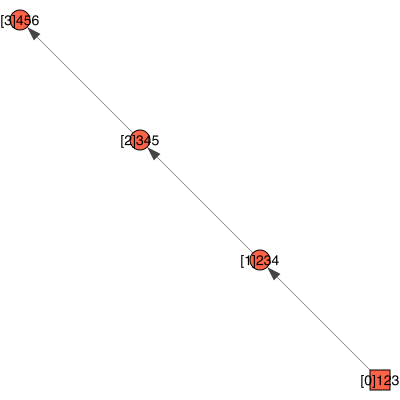

In [12]:
g = DBGraph('hey joe')
g.add('123','234')
g.add('234','345')
g.add('345','456')
g.viz()


In [13]:
g.assemble()


walk:  123 123
walk:  234
seq:  4
walk:  345
seq:  5
walk:  456
seq:  6
Done


['123456']

adding edge 0 --> 0
adding edge 1 --> 2
adding edge 2 --> 3
adding edge 3 --> 4
adding edge 4 --> 5
adding edge 4 --> 6
adding edge 6 --> 7
adding edge 7 --> 8
adding edge 7 --> 9
adding edge 9 --> 10
adding edge 10 --> 11
adding edge 5 --> 11
adding edge 2 --> 12
adding edge 2 --> 12
adding edge 2 --> 12
adding edge 12 --> 13
adding edge 12 --> 13
adding edge 13 --> 14
adding edge 13 --> 14
adding edge 14 --> 11
adding edge 11 --> 15
IGRAPH DN-- 16 17 --
+ attr: compacted (v), coverage (v), id (v), label (v), name (v), sequence
  (v), visited (v), coverage (e)
+ edges (vertex names):
ttt->ttt, abb->bbb, bbb->bba, bba->bas, bas->asu, bas->ast, ast->stu,
stu->tup, stu->tus, tus->usu, usu->suu, asu->suu, bbb->bbA, bbA->bAs,
bAs->Asu, Asu->suu, suu->uuu


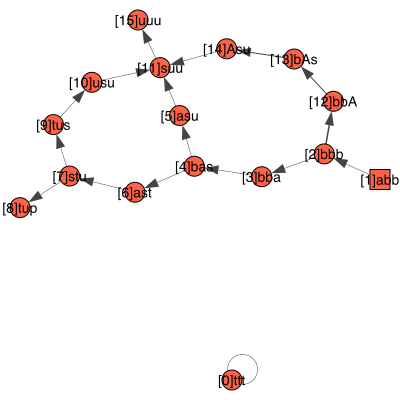

In [14]:
g = DBGraph('hey joe')

g.add_kmer('tttt')
## bubble graph
g.add('abb','bbb')
g.add('bbb','bba')
g.add('bba','bas')
g.add('bas','asu')
g.add('bas','ast')
g.add('ast','stu')
g.add('stu','tup')
g.add('stu','tus')
g.add('tus','usu')
g.add('usu','suu')

g.add('asu','suu')
g.add('bbb','bbA')
g.add('bbb','bbA')
g.add('bbb','bbA')
g.add('bbA','bAs')
g.add('bbA','bAs')
g.add('bAs','Asu')
g.add('bAs','Asu')
g.add('Asu','suu')
g.add('suu','uuu')

## alternative start and end nodes
## g.add("NAT","ATG")
# g.add("NAT","ATG")
# g.add("NAT","ATG")
# g.add("XAT","ATG")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")
# g.add("ATG", "TGA")

n = g.igraph.vs[1]
g.print()
g.viz()



0 : 11
Start compacting:  ttt
1 : 10
Start compacting:  abb
compacting abb --> igraph.Vertex(<igraph.Graph object at 0x7fe0f5115d60>, 2, {'name': 'bbb', 'sequence': 'bbb', 'label': '[2]bbb', 'id': 2, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
2 : 9
Start compacting:  bba
compacting bba --> igraph.Vertex(<igraph.Graph object at 0x7fe0f5115d60>, 3, {'name': 'bas', 'sequence': 'bas', 'label': '[4]bas', 'id': 4, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
3 : 8
Start compacting:  asu
4 : 7
Start compacting:  ast
compacting ast --> igraph.Vertex(<igraph.Graph object at 0x7fe0f5115d60>, 5, {'name': 'stu', 'sequence': 'stu', 'label': '[7]stu', 'id': 7, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
5 : 6
Start compacting:  tus
compacting tus --> igraph.Vertex(<igraph.Graph object at 0x7fe0f5115d60>, 7, {'name': 'usu', 'sequence': 'usu', 'label': '[10]usu', 'id': 10, 'visited': False, '

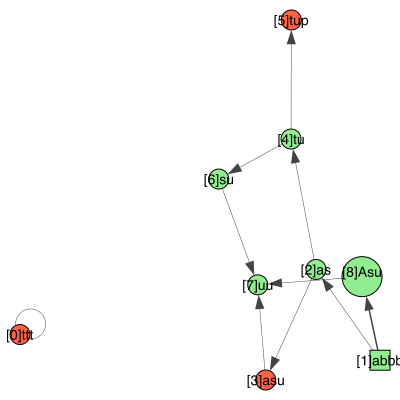

In [15]:
g.compact()
g.print()
g.viz()






In [16]:
g.remove_bubbles()
g.viz()
g.assemble()

1 : bubble detected: abbb ---> uu
[[2, 3, 7], [8, 7]]
deleting the following nodes: [3]
2 : bubble detected: abbb ---> uu
[[2, 3, 5, 6], [7, 6]]
deleting the following nodes: [2, 5]
walk:  abbb abbb
walk:  Asu
seq:  Asu
walk:  uu
seq:  uu
Done
walk:  tu tu
walk:  tup
seq:  p
Done
walk:  ttt ttt
Done


['abbbAsuuu']

adding edge 0 --> 1
adding edge 1 --> 2
adding edge 2 --> 3
adding edge 2 --> 4
adding edge 3 --> 5
adding edge 4 --> 6
adding edge 5 --> 7
adding edge 6 --> 8
adding edge 7 --> 1
adding edge 8 --> 1


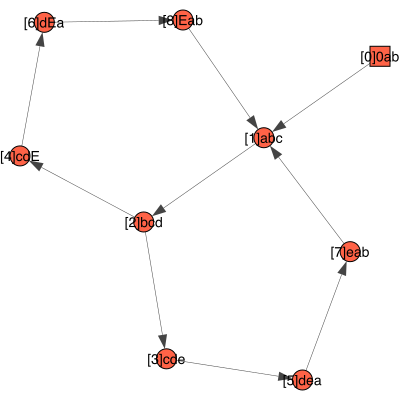

In [19]:
g = DBGraph('double loop')
g.add('0ab','abc')
g.add('abc','bcd')
g.add('bcd','cde')
g.add('bcd','cdE')
g.add('cde','dea')
g.add('cdE','dEa')
g.add('dea','eab')
g.add('dEa','Eab')
g.add('eab','abc')
g.add('Eab','abc')
g.viz()


0 : 8
Start compacting:  0ab
1 : 7
Start compacting:  abc
compacting abc --> igraph.Vertex(<igraph.Graph object at 0x7fe0f7058e50>, 2, {'name': 'bcd', 'sequence': 'bcd', 'label': '[2]bcd', 'id': 2, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
2 : 6
Start compacting:  cde
compacting cde --> igraph.Vertex(<igraph.Graph object at 0x7fe0f7058e50>, 4, {'name': 'dea', 'sequence': 'dea', 'label': '[5]dea', 'id': 5, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
compacting ea --> igraph.Vertex(<igraph.Graph object at 0x7fe0f7058e50>, 5, {'name': 'eab', 'sequence': 'eab', 'label': '[7]eab', 'id': 7, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
3 : 3
Start compacting:  cdE
compacting cdE --> igraph.Vertex(<igraph.Graph object at 0x7fe0f7058e50>, 4, {'name': 'dEa', 'sequence': 'dEa', 'label': '[6]dEa', 'id': 6, 'visited': False, 'compacted': False, 'coverage': 1, 'sum': None, 'dist': None})
c

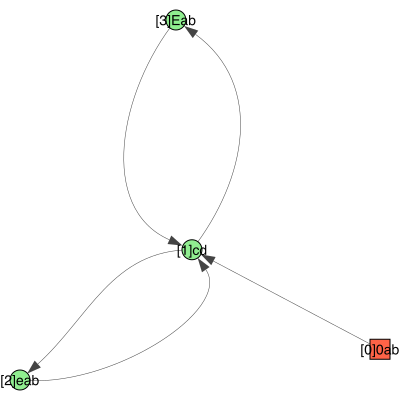

In [21]:
g.compact()
g.viz()

1 : bubble detected: cd ---> eab
[[2], [3, 1, 2]]
deleting the following nodes: []


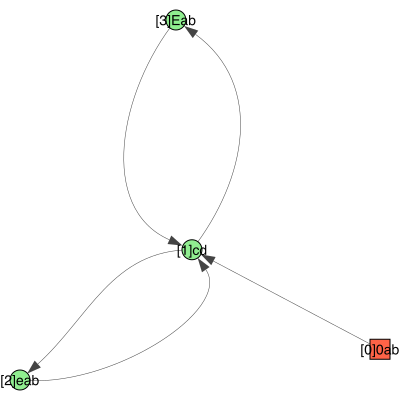

In [22]:
g.remove_bubbles()
g.viz()

In [23]:
g.assemble() # should give: ['0abcdeabcdEabcd']

walk:  0ab 0ab
walk:  cd
seq:  cd
walk:  eab
seq:  eab
walk:  cd
seq:  cd
walk:  Eab
seq:  Eab
walk:  cd
seq:  cd
Done


['0abcdeabcdEabcd']